## A tutorial to visualize forensic evidence and relationships

### Motivation
- An evidence graph can enhance investigators' understanding of evidence entities and their relationships.

### Goal
- Familiar with Graph Visualization Software (graphviz)
    -  an open-source graph visualization software developed by AT&T Labs Research.
- Generate graph directly from the conversation
- Gain criminal insights visually using graphviz. 

### Step 1: Download libraries and files for the lab
- Make use you download necessary library and files. 
- All downloaded and saved files can be located in the `content` folder if using google Colab

In [4]:
# uncomment the commands to download libraries and files
#!pip install python-dotenv
#!pip install dspy-ai
#!pip install graphviz
# !wget https://raw.githubusercontent.com/frankwxu/digital-forensics-lab/main/AI4Forensics/CKIM2024/PhishingAttack/PhishingAttackScenarioDemo/conversation.txt

import dspy
import os
import openai
import json
from dotenv import load_dotenv
from graphviz import Source
from IPython.display import display

### Step 2: Config DSPy with openAI 
- You `MUST` have an openAI api key
- load an openAI api key from `openai_api_key.txt` file
- or, hard code your open api key

In [5]:
def set_dspy():
    # ==============set openAI enviroment=========
    # Path to your API key file
    key_file_path = "openai_api_key.txt"

    # Load the API key from the file
    with open(key_file_path, "r") as file:
        openai_api_key = file.read().strip()

    # Set the API key as an environment variable
    os.environ["OPENAI_API_KEY"] = openai_api_key
    openai.api_key = os.environ["OPENAI_API_KEY"]
    turbo = dspy.OpenAI(model="gpt-3.5-turbo", max_tokens=2000, temperature=0.5)
    dspy.settings.configure(lm=turbo)
    return turbo
    # ==============end of set openAI enviroment=========


def set_dspy_hardcode_openai_key():
    os.environ["OPENAI_API_KEY"] = "sk-proj-yourapikeyhere"
    openai.api_key = os.environ["OPENAI_API_KEY"]
    turbo = dspy.OpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=2000)
    dspy.settings.configure(lm=turbo)
    return turbo


# provide `openai_api_key.txt` with your openAI api key
turbo = set_dspy()
# optionally, hard code your openAI api key at line 21
# turbo=set_dspy_hardcode_openai_key()

### Step 3: Load the cyber incident repot (e.g., conversation)

- the same conversation as previous tutorial

In [6]:
def load_text_file(file_path):
    """
    Load a text file and return its contents as a string.

    Parameters:
    file_path (str): The path to the text file.

    Returns:
    str: The contents of the text file.
    """
    try:
        with open(file_path, "r") as file:
            contents = file.read()
        return contents
    except FileNotFoundError:
        return "File not found."
    except Exception as e:
        return f"An error occurred: {e}"

conversation = load_text_file("conversation.txt")
print(conversation)

Alice: Hey Bob, I just got a strange email from support@banksecure.com. It says I need to verify my account details urgently. The subject line was "Urgent: Verify Your Account Now". The email looks suspicious to me.

Bob: Hi Alice, that does sound fishy. Can you forward me the email? I’ll take a look at the headers to see where it came from.

Alice: Sure, forwarding it now.

Bob: Got it. Let’s see... The email came from IP address 192.168.10.45, but the domain banksecure.com is not their official domain. It's actually registered to someone in Russia.

Alice: That’s definitely not right. Should I be worried?

Bob: We should investigate further. Did you click on any links or download any attachments?

Alice: I did click on a link that took me to a page asking for my login credentials. I didn't enter anything though. The URL was http://banksecure-verification.com/login.

Bob: Good call on not entering your details. Let’s check the URL. This domain was just registered two days ago. It’s hi

### Step 4: Tell an LLM `WHAT` are the inputs/outputs by defining DSPy: Signature 

- Goal
    - to generate a simple plaintext file, call `DOT`. In DOT, you define nodes and edges.
    - Graphviz uses ``DOT` to describe and visualize graphs.  

- The following signature identifies a list of evidence entities and relationships based on the conversation
    - Inherit from `dspy.Signature`
    - Exact `ONE` input, e.g., the conversation 
    - Exact `ONE` output, a DOT file

In [7]:
class DotGenerator(dspy.Signature):
    """Generate a foresnic evidence knowledge graph based on a conversation between an IT Security Specialist and an Employee. """

    question: str = dspy.InputField(
        desc="a conversation describing a cyber incident between an IT Security Specialist and an employee."
    )

    answer: str = dspy.OutputField(
        desc="a graph in a dot format. The nodes of the graph are evidence entities and the edges of the graph are the relationships between evidence entities. A DOT format is primarily associated with Graphviz, a graph visualization software. For example, a DOT should looks like: digraph incident_name {...}. Don't include `````` "
    )

### Step 5: Tell an LLM `HOW` to generate answer: 

Generates and saves DOT file from a conversation using a specified signature.

#### Parameters:
- `signature` (dspy.Signature): The signature defining the input and output structure for evidence identification.
- `conversation` (str): The conversation text to analyze for evidence.
- `output_file` (str): The file path where the identified evidence will be saved in DOT format.

#### Notes:
- This function uses [`dspy.ChainOfThought`](https://arxiv.org/pdf/2201.11903) to process the conversation and create sknowledge graph
- Other options include 
    - `dspy.ChainOfThoughtWithHint` : Provide hints for reasoning
    - `dspy.Retrieve`: Retrieves passages from a retriever module
    - `dspy.ReAct`: Consists steps of Thought, Action, and Observation.


In [8]:
def generate_answer_CoT(signature, text, output_file):
    generate_answer = dspy.ChainOfThought(signature)
    answer = generate_answer(question=text).answer  # here we use the module

    with open(output_file, "w") as dot_file:
        print(answer)
        dot_file.write(answer)
        return answer
    print(f"The evidence has been saved to the file {output_file}")

### Step 6: Call LLM to generate the graph in a `.DOT` file

In [9]:
output_file = "02_output.dot"
dot_description = generate_answer_CoT(
    DotGenerator,
    conversation,
    output_file,
)

digraph phishing_incident {
    "Email from support@banksecure.com" -> "IP address 192.168.10.45";
    "Email from support@banksecure.com" -> "Domain banksecure.com";
    "Domain banksecure.com" -> "Registered to someone in Russia";
    "URL http://banksecure-verification.com/login" -> "Domain registered two days ago";
    "URL http://banksecure-verification.com/account-details" -> "Domain registered two days ago";
    "Browser history entries" -> "Visited at 10:15 AM: http://banksecure-verification.com/login";
    "Browser history entries" -> "Visited at 10:17 AM: http://banksecure-verification.com/account-details";
    "Downloaded file AccountDetails.exe" -> "Created at 10:20 AM";
    "Downloaded file AccountDetails.exe" -> "MD5 hash e99a18c428cb38d5f260853678922e03";
    "MD5 hash e99a18c428cb38d5f260853678922e03" -> "Matches known malware in database";
    "IP address 192.168.10.45" -> "Network connections established";
    "Security measures" -> "Clear browser history and cache";


### Step 7: Render the graph based on the `.DOT` file 

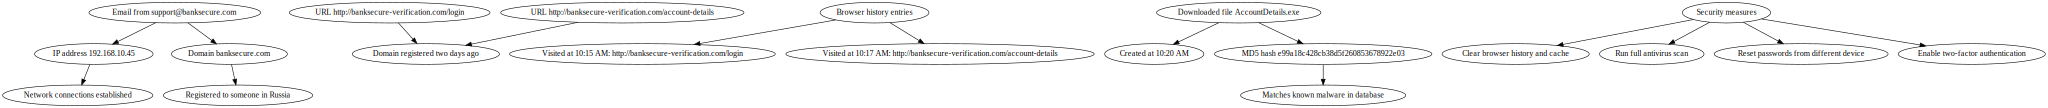

'02_output_email_analysis.png'

In [10]:
# Create a Digraph object and render the graph
graph = Source(dot_description)
display(graph)

# Render the graph within the notebook
graph.render("02_output_email_analysis", format="png", cleanup=True)

### Step 7: Inspect the last prompt send to the LLM

You want to check:
- Prompt Description Section: Description in the signature
- Format Section: `Following the following format.` 
    - Pay attention to a new inserted field `REASONING: Let's think step by step ...`
- Result Section: a forensic knowledge graph in `.DOT`

In [11]:
turbo.inspect_history(n=1)




Generate a foresnic evidence knowledge graph based on a conversation between an IT Security Specialist and an Employee.

---

Follow the following format.

Question: a conversation describing a cyber incident between an IT Security Specialist and an employee.
Reasoning: Let's think step by step in order to ${produce the answer}. We ...
Answer: a graph in a dot format. The nodes of the graph are evidence entities and the edges of the graph are the relationships between evidence entities. A DOT format is primarily associated with Graphviz, a graph visualization software. For example, a DOT should looks like: digraph incident_name {...}. Don't include ``````

---

Question: Alice: Hey Bob, I just got a strange email from support@banksecure.com. It says I need to verify my account details urgently. The subject line was "Urgent: Verify Your Account Now". The email looks suspicious to me. Bob: Hi Alice, that does sound fishy. Can you forward me the email? I’ll take a look at the headers t

'\n\n\nGenerate a foresnic evidence knowledge graph based on a conversation between an IT Security Specialist and an Employee.\n\n---\n\nFollow the following format.\n\nQuestion: a conversation describing a cyber incident between an IT Security Specialist and an employee.\nReasoning: Let\'s think step by step in order to ${produce the answer}. We ...\nAnswer: a graph in a dot format. The nodes of the graph are evidence entities and the edges of the graph are the relationships between evidence entities. A DOT format is primarily associated with Graphviz, a graph visualization software. For example, a DOT should looks like: digraph incident_name {...}. Don\'t include ``````\n\n---\n\nQuestion: Alice: Hey Bob, I just got a strange email from support@banksecure.com. It says I need to verify my account details urgently. The subject line was "Urgent: Verify Your Account Now". The email looks suspicious to me. Bob: Hi Alice, that does sound fishy. Can you forward me the email? I’ll take a loo